In [7]:
import os
import sys
import re

project_root = "/root/work/tenset"
os.environ["TVM_HOME"] = f"{project_root}"
os.environ["TVM_LIBRARY_PATH"] = f"{project_root}/build"
if f"{project_root}/python" not in sys.path:
    sys.path.insert(0, f"{project_root}/python")

sys.path = [p for p in sys.path if not p.startswith(f"{project_root}/build")]
sys.path.append(f"{project_root}/build")
os.environ["LD_LIBRARY_PATH"] = f"{project_root}/build:" + os.environ.get("LD_LIBRARY_PATH", "")

In [8]:
import argparse
import logging
import pickle
import random

import torch
import numpy as np

import tvm
from tvm.auto_scheduler.utils import to_str_round
from tvm.auto_scheduler.cost_model import RandomModelInternal

sys.path.append("/root/work/tenset/scripts")
from common import load_and_register_tasks, str2bool
from train_model import train_zero_shot

from tvm.auto_scheduler.dataset import Dataset, LearningTask
from tvm.auto_scheduler.cost_model.xgb_model import XGBModelInternal
from tvm.auto_scheduler.cost_model.mlp_model import MLPModelInternal
from tvm.auto_scheduler.cost_model.lgbm_model import LGBModelInternal
from tvm.auto_scheduler.cost_model.tabnet_model import TabNetModelInternal
from tvm.auto_scheduler.cost_model.metric import (
    metric_rmse,
    metric_r_squared,
    metric_pairwise_comp_accuracy,
    metric_top_k_recall,
    metric_peak_score,
    metric_mape,
    random_mix,
)

load_and_register_tasks()
dataset = pickle.load(open("../../dataset.pkl", "rb"))
train_set, test_set = dataset.random_split_within_task(0.9)

tenset_model = MLPModelInternal()
tenset_model.fit_base(train_set, valid_set=test_set)

cuda:0
Fit a net. Train size: 3600
Epoch: 0	Batch: 7	Train Loss: 59.0514	Valid Loss: 22.6778	Train Speed: 84927
Epoch: 5	Batch: 7	Train Loss: 21.4726	Valid Loss: 5.2499	Train Speed: 87039
Epoch: 10	Batch: 7	Train Loss: 8.8188	Valid Loss: 2.8222	Train Speed: 85839
Epoch: 15	Batch: 7	Train Loss: 4.9773	Valid Loss: 2.2249	Train Speed: 83505
Epoch: 20	Batch: 7	Train Loss: 3.6460	Valid Loss: 2.0474	Train Speed: 84976
Epoch: 25	Batch: 7	Train Loss: 3.2160	Valid Loss: 1.7836	Train Speed: 85685
Epoch: 30	Batch: 7	Train Loss: 3.0676	Valid Loss: 1.5096	Train Speed: 85443
Epoch: 35	Batch: 7	Train Loss: 2.8211	Valid Loss: 1.1636	Train Speed: 84908
Epoch: 40	Batch: 7	Train Loss: 2.9690	Valid Loss: 3.1208	Train Speed: 67502
Epoch: 45	Batch: 7	Train Loss: 2.5528	Valid Loss: 1.1521	Train Speed: 74622
Epoch: 49	Batch: 7	Train Loss: 2.3508	Valid Loss: 1.0303	Train Speed: 86419


In [10]:
# SegmentDataLoader 패턴에 맞춰 데이터 준비
raw_features = list(dataset.features.values())
raw_throughputs = list(dataset.throughputs.values())

# 가변 길이 features와 labels를 리스트로 저장
features_list = []  # 각 샘플의 feature (seq_len, feature_dim)
costs = []
segment_sizes_list = []  # 각 샘플의 segment 길이
for raw_feature, raw_throughput in zip(raw_features, raw_throughputs):
    for feature, throughput in zip(raw_feature, raw_throughput):
        if feature.shape[0] != 1 and throughput > 1e-10 :  # segment 길이가 1이 아닌 것만
            features_list.append(feature)
            costs.append(-np.log(throughput))
            segment_sizes_list.append(feature.shape[0])

# numpy array로 변환
costs = np.array(costs, dtype=np.float32)
segment_sizes = np.array(segment_sizes_list, dtype=np.int32)

# 모든 features를 flatten (SegmentDataLoader 방식)
flatten_features = np.concatenate(features_list, axis=0).astype(np.float32)

print(f"총 샘플 수: {len(costs)}")
print(f"Flatten된 features shape: {flatten_features.shape}")
print(f"Segment sizes - Min: {segment_sizes.min()}, Max: {segment_sizes.max()}, Mean: {segment_sizes.mean():.2f}")

총 샘플 수: 3464
Flatten된 features shape: (27712, 164)
Segment sizes - Min: 8, Max: 8, Mean: 8.00


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader
import random

# 시드 고정
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

class SegmentRegressionDataset:
    """SegmentDataLoader 패턴을 따르는 데이터셋"""
    def __init__(self, segment_sizes, features, labels, batch_size, device, 
                 fea_norm_vec=None, shuffle=False, seed=42):
        self.device = device
        self.shuffle = shuffle
        self.seed = seed
        self.number = len(labels)
        self.batch_size = batch_size
        
        self.segment_sizes = torch.tensor(segment_sizes, dtype=torch.int32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.features = torch.tensor(features, dtype=torch.float32)
        
        if fea_norm_vec is not None:
            self.normalize(fea_norm_vec)
        
        self.feature_offsets = (
            torch.cumsum(self.segment_sizes, 0, dtype=torch.int32) - self.segment_sizes
        ).cpu().numpy()
        
        self.iter_order = self.pointer = None
        self.rng = np.random.RandomState(seed)
    
    def normalize(self, norm_vector=None):
        if norm_vector is None:
            norm_vector = torch.ones((self.features.shape[1],))
            for i in range(self.features.shape[1]):
                max_val = self.features[:, i].max().item()
                if max_val > 0:
                    norm_vector[i] = max_val
        self.features /= norm_vector
        return norm_vector
    
    def __iter__(self):
        if self.shuffle:
            self.iter_order = torch.from_numpy(self.rng.permutation(self.number))
        else:
            self.iter_order = torch.arange(self.number)
        self.pointer = 0
        return self
    
    def __next__(self):
        if self.pointer >= self.number:
            raise StopIteration
        
        batch_indices = self.iter_order[self.pointer: self.pointer + self.batch_size]
        self.pointer += self.batch_size
        return self._fetch_indices(batch_indices)
    
    def _fetch_indices(self, indices):
        segment_sizes = self.segment_sizes[indices]
        
        feature_offsets = self.feature_offsets[indices]
        feature_indices = np.empty((segment_sizes.sum().item(),), dtype=np.int32)
        ct = 0
        for offset, seg_size in zip(feature_offsets, segment_sizes.numpy()):
            feature_indices[ct: ct + seg_size] = np.arange(offset, offset + seg_size, 1)
            ct += seg_size
        
        features = self.features[feature_indices]
        labels = self.labels[indices]
        return (x.to(self.device) for x in (segment_sizes, features, labels))
    
    def __len__(self):
        return self.number


# Train/Val 분할
n_samples = len(costs)
indices = np.arange(n_samples)
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=SEED)

train_segment_sizes = segment_sizes[train_indices]
val_segment_sizes = segment_sizes[val_indices]
train_labels = costs[train_indices]
val_labels = costs[val_indices]

train_feature_list = [features_list[i] for i in train_indices]
val_feature_list = [features_list[i] for i in val_indices]

train_flatten_features = np.concatenate(train_feature_list, axis=0).astype(np.float32)
val_flatten_features = np.concatenate(val_feature_list, axis=0).astype(np.float32)

print(f"훈련 샘플 수: {len(train_labels)}, 검증 샘플 수: {len(val_labels)}")
print(f"훈련 flatten features: {train_flatten_features.shape}")
print(f"검증 flatten features: {val_flatten_features.shape}")

# 정규화
fea_norm_vec = torch.ones((train_flatten_features.shape[1],))
for i in range(train_flatten_features.shape[1]):
    max_val = float(train_flatten_features[:, i].max())
    if max_val > 0:
        fea_norm_vec[i] = max_val

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = SegmentRegressionDataset(
    train_segment_sizes, train_flatten_features, train_labels,
    batch_size=128, device=device, fea_norm_vec=fea_norm_vec, shuffle=True, seed=SEED
)
val_loader = SegmentRegressionDataset(
    val_segment_sizes, val_flatten_features, val_labels,
    batch_size=128, device=device, fea_norm_vec=fea_norm_vec, shuffle=False, seed=SEED
)

X_train = train_flatten_features
X_val = val_flatten_features
y_train = train_labels
y_val = val_labels
train_dataset = train_loader
val_dataset = val_loader

훈련 샘플 수: 2771, 검증 샘플 수: 693
훈련 flatten features: (22168, 164)
검증 flatten features: (5544, 164)


## VAE Feature Pre-training (Reconstruction + β·KLD)

Feature만 입력으로 사용하여 VAE encoder representation을 먼저 학습합니다.
- Reconstruction loss: MSE로 원본 feature를 복원
- KL Divergence: latent 분포를 N(0, I)에 가깝게 정규화
- β 자동 탐색: 1e-3~1e-2 범위에서 최적값 탐색

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import r2_score
import random

# 시드 고정
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

class SegmentAE(nn.Module):
    """
    Segment-level VAE:
    1. Segment Encoder: 각 row를 hidden_dim으로 변환
    2. Segment Sum: row들을 segment별로 합산
    3. VAE: 합산된 벡터를 encode → decode (reconstruction)
    """
    def __init__(self, input_dim, hidden_dim=256, latent_dim=64, dropout=0.1):
        super(SegmentAE, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # ========== Segment Encoder (VAE 전에 적용) ==========
        self.segment_encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # ========== VAE Encoder (segment sum 후 적용) ==========
        self.norm = nn.BatchNorm1d(hidden_dim)
        
        # Residual 레이어들
        self.l0 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.l1 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # VAE latent parameters
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        
        # ========== VAE Decoder (hidden_dim으로 reconstruction) ==========
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),  # 출력: segment sum 벡터 (hidden_dim)
        )
        
    def segment_sum(self, segment_sizes, features):
        """SegmentSum: 각 segment 내 row들을 합산"""
        n_seg = segment_sizes.shape[0]
        device = features.device
        segment_sizes = segment_sizes.long()
        
        segment_indices = torch.repeat_interleave(
            torch.arange(n_seg, device=device), segment_sizes
        )
        
        n_dim = features.shape[1]
        segment_sum = torch.scatter_add(
            torch.zeros((n_seg, n_dim), dtype=features.dtype, device=device),
            0,
            segment_indices.view(-1, 1).expand(-1, n_dim),
            features,
        )
        return segment_sum
    
    def encode(self, h):
        """VAE Encoder: segment sum 벡터 → (mean, logvar)"""
        # BatchNorm
        h = self.norm(h)
        
        # Residual connections
        h = self.l0(h) + h
        h = self.l1(h) + h
        
        # Latent parameters
        mean = self.fc_mean(h)
        return mean

    
    def decode(self, z):
        """VAE Decoder: latent z → reconstructed segment sum 벡터"""
        return self.decoder(z)
    
    def forward(self, segment_sizes, features):
        """
        Forward pass:
        1. Segment Encoder: features → hidden
        2. Segment Sum: hidden → segment-level 벡터
        3. VAE: encode → reparameterize → decode
        """
        # 1. Segment Encoder
        h = self.segment_encoder(features)  # (total_rows, hidden_dim)
        
        # 2. Segment Sum
        segment_sum_vec = self.segment_sum(segment_sizes, h)  # (n_seg, hidden_dim)
        
        # 3. VAE Encode
        z = self.encode(segment_sum_vec)

        
        # 5. VAE Decode (reconstruct segment sum 벡터)
        recon = self.decode(z)  # (n_seg, hidden_dim)
        
        return z, recon, segment_sum_vec


def ae_loss(recon, original):
    """
    VAE Loss = Reconstruction Loss + β * KL Divergence
    - Reconstruction: MSE between original and reconstructed segment sum 벡터
    - KLD: D_KL(q(z|x) || p(z)), where p(z) = N(0, I)
    """
    recon_loss = F.mse_loss(recon, original, reduction='sum')

    total_loss = recon_loss
    return total_loss, recon_loss


print("Segment VAE 모델 정의 완료!")
print(f"- Input dim: {train_flatten_features.shape[1]}")
print(f"- Hidden dim: 256")
print(f"- Latent dim: 64")
print("Flow: features → segment_encoder → segment_sum → VAE (encode/decode)")

Segment VAE 모델 정의 완료!
- Input dim: 164
- Hidden dim: 256
- Latent dim: 64
Flow: features → segment_encoder → segment_sum → VAE (encode/decode)


In [26]:
# 하이퍼파라미터 탐색을 위한 AE 학습 함수
from itertools import product
import copy

def train_ae_single_config(train_loader, val_loader, input_dim, device,
                            hidden_dim, latent_dim, lr, dropout=0.1,
                            num_epochs=100, patience=40, verbose=False):
    """단일 설정으로 AE 학습"""
    
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
    
    model = SegmentAE(input_dim, hidden_dim, latent_dim, dropout).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=30, T_mult=2)
    
    best_recon_r2 = -float('inf')
    patience_counter = 0
    best_state = None
    history = {'recon_r2': [], 'recon_loss': []}
    
    for epoch in range(num_epochs):
        model.train()
        epoch_recon = 0.0
        n_batches = 0
        
        for segment_sizes_batch, features_batch, _ in train_loader:
            z, recon, segment_sum_vec = model(segment_sizes_batch, features_batch)
            loss, recon_loss = ae_loss(recon, segment_sum_vec)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_recon += recon_loss.item() / z.shape[0]
            n_batches += 1
        
        scheduler.step()
        avg_recon = epoch_recon / n_batches
        
        # Validation
        model.eval()
        val_recons, val_originals = [], []
        
        with torch.no_grad():
            for segment_sizes_batch, features_batch, _ in val_loader:
                z, recon, segment_sum_vec = model(segment_sizes_batch, features_batch)
                val_recons.append(recon.cpu().numpy())
                val_originals.append(segment_sum_vec.cpu().numpy())
        
        recon_r2 = r2_score(
            np.concatenate(val_originals).flatten(),
            np.concatenate(val_recons).flatten()
        )
        
        history['recon_r2'].append(recon_r2)
        history['recon_loss'].append(avg_recon)
        
        if recon_r2 > best_recon_r2:
            best_recon_r2 = recon_r2
            patience_counter = 0
            best_state = copy.deepcopy(model.state_dict())
        else:
            patience_counter += 1
        
        if verbose and (epoch + 1) % 50 == 0:
            print(f"  Epoch {epoch+1}: R²={recon_r2:.4f}")
        
        if patience_counter >= patience:
            break
    
    # 최고 성능 모델 로드
    if best_state is not None:
        model.load_state_dict(best_state)
    
    return model, best_recon_r2, history


def hyperparameter_search(train_loader, val_loader, input_dim, device,
                          target_r2=0.95, num_epochs=300, patience=40):
    """
    하이퍼파라미터 탐색:
    - R² 기준으로 최적 설정 탐색
    """
    
    # 하이퍼파라미터 그리드
    configs = [
        {'hidden_dim': 256, 'latent_dim': 64,  'lr': 1e-03},
        {'hidden_dim': 256, 'latent_dim': 64,  'lr': 2e-04},
        {'hidden_dim': 256, 'latent_dim': 64,  'lr': 5e-04},

        {'hidden_dim': 256, 'latent_dim': 128, 'lr': 1e-03},
        {'hidden_dim': 256, 'latent_dim': 128, 'lr': 5e-04},
        {'hidden_dim': 256, 'latent_dim': 128, 'lr': 2e-04},

        {'hidden_dim': 512, 'latent_dim': 128, 'lr': 2e-04},
        {'hidden_dim': 512, 'latent_dim': 128, 'lr': 5e-04},
        {'hidden_dim': 512, 'latent_dim': 128, 'lr': 1e-03},
    ]
    
    all_results = []
    best_r2 = -float('inf')
    best_config = None
    best_model = None
    
    total_configs = len(configs)

    print("=" * 70)
    print("AE 하이퍼파라미터 탐색")
    print("=" * 70)
    print(f"목표 R²: >= {target_r2}")
    print(f"Configurations to try ({total_configs}개)")
    print()

    for config_idx, config in enumerate(configs, 1):
        hidden_dim = config['hidden_dim']
        latent_dim = config['latent_dim']
        lr = config['lr']
        
        print(f"\n[{config_idx}/{total_configs}] hidden={hidden_dim}, latent={latent_dim}, lr={lr:.0e}")
        
        try:
            model, recon_r2, history = train_ae_single_config(
                train_loader, val_loader, input_dim, device,
                hidden_dim=hidden_dim,
                latent_dim=latent_dim,
                lr=lr,
                num_epochs=num_epochs,
                patience=patience,
                verbose=False
            )
            
            result = {
                **config,
                'recon_r2': recon_r2,
                'model': model,
                'history': history
            }
            all_results.append(result)
            
            # 최고 성능 업데이트
            if recon_r2 > best_r2:
                best_r2 = recon_r2
                best_config = config
                best_model = model
            
            print(f"  → R²={recon_r2:.4f}")
            
        except Exception as e:
            print(f"  오류: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    # 결과 정렬 및 출력
    print("\n" + "=" * 70)
    print("탐색 결과 (R² 기준 상위 10개)")
    print("=" * 70)
    
    sorted_results = sorted(all_results, key=lambda x: x['recon_r2'], reverse=True)
    
    print(f"{'Rank':<5} {'Hidden':<8} {'Latent':<8} {'LR':<10} {'R²':<8}")
    print("-" * 50)
    
    for i, res in enumerate(sorted_results[:10]):
        print(f"{i+1:<5} {res['hidden_dim']:<8} {res['latent_dim']:<8} {res['lr']:<10.0e} {res['recon_r2']:<8.4f}")
    
    print("\n" + "=" * 70)
    print("최적 설정")
    print("=" * 70)
    print(f"Hidden dim: {best_config['hidden_dim']}")
    print(f"Latent dim: {best_config['latent_dim']}")
    print(f"Learning rate: {best_config['lr']}")
    print(f"R²: {best_r2:.4f}")
    
    return best_model, best_config, sorted_results


print("하이퍼파라미터 탐색 함수 정의 완료!")

하이퍼파라미터 탐색 함수 정의 완료!


In [27]:
# AE 하이퍼파라미터 탐색 실행
print("=" * 60)
print("AE 하이퍼파라미터 탐색 시작")
print("=" * 60)

input_dim = train_flatten_features.shape[1]

pretrained_ae, best_config, all_results = hyperparameter_search(
    train_loader, val_loader, input_dim, device,
    target_r2=0.95,
    num_epochs=200,
    patience=20
)

print("\n" + "=" * 60)
print("AE 하이퍼파라미터 탐색 완료!")
print("=" * 60)

AE 하이퍼파라미터 탐색 시작
AE 하이퍼파라미터 탐색
목표 R²: >= 0.95
Configurations to try (9개)


[1/9] hidden=256, latent=64, lr=1e-03
  → R²=0.9947

[2/9] hidden=256, latent=64, lr=2e-04
  → R²=0.9947

[2/9] hidden=256, latent=64, lr=2e-04
  → R²=0.9739

[3/9] hidden=256, latent=64, lr=5e-04
  → R²=0.9739

[3/9] hidden=256, latent=64, lr=5e-04
  → R²=0.9849

[4/9] hidden=256, latent=128, lr=1e-03
  → R²=0.9849

[4/9] hidden=256, latent=128, lr=1e-03
  → R²=0.9945

[5/9] hidden=256, latent=128, lr=5e-04
  → R²=0.9945

[5/9] hidden=256, latent=128, lr=5e-04
  → R²=0.9850

[6/9] hidden=256, latent=128, lr=2e-04
  → R²=0.9850

[6/9] hidden=256, latent=128, lr=2e-04
  → R²=0.9822

[7/9] hidden=512, latent=128, lr=2e-04
  → R²=0.9822

[7/9] hidden=512, latent=128, lr=2e-04
  → R²=0.9652

[8/9] hidden=512, latent=128, lr=5e-04
  → R²=0.9652

[8/9] hidden=512, latent=128, lr=5e-04
  → R²=0.9889

[9/9] hidden=512, latent=128, lr=1e-03
  → R²=0.9889

[9/9] hidden=512, latent=128, lr=1e-03
  → R²=0.9420

탐색 결과 (R² 기준

In [30]:
# ============================================================
# AECostPredictor: Pretrained AE + Cost Predictor
# ============================================================

class AECostPredictor(nn.Module):
    """
    Pretrained AE encoder + Cost Predictor
    
    구조:
    1. Segment Encoder (pretrained)
    2. Segment Sum (pretrained)
    3. AE Encoder (pretrained): segment_sum → latent z
    4. Cost Predictor (새로 학습): z → cost
    
    특징:
    - VAE와 달리 KL divergence 없음
    - Deterministic encoding (no sampling)
    - 전체 forward 경로 미분 가능
    - Encoder/Predictor 분리 학습률 지원
    """
    def __init__(self, input_dim, hidden_dim=256, latent_dim=64, 
                 predictor_hidden=256, predictor_layers=3, dropout=0.1):
        super(AECostPredictor, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # ========== Segment Encoder (pretrained from AE) ==========
        self.segment_encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # ========== AE Encoder (pretrained from AE) ==========
        self.norm = nn.BatchNorm1d(hidden_dim)
        self.l0 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU())
        self.l1 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU())
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)  # AE는 mean만 사용 (no logvar)
        
        # ========== Cost Predictor (새로 학습) ==========
        predictor_modules = []
        current_dim = latent_dim
        for i in range(predictor_layers):
            predictor_modules.extend([
                nn.Linear(current_dim, predictor_hidden),
                nn.BatchNorm1d(predictor_hidden),
                nn.ReLU(),
                nn.Dropout(dropout) if i < predictor_layers - 1 else nn.Identity(),
            ])
            current_dim = predictor_hidden
        predictor_modules.append(nn.Linear(predictor_hidden, 1))
        
        self.cost_predictor = nn.Sequential(*predictor_modules)
        
    def segment_sum(self, segment_sizes, features):
        """SegmentSum: 각 segment 내 row들을 합산"""
        n_seg = segment_sizes.shape[0]
        device = features.device
        segment_sizes = segment_sizes.long()
        
        segment_indices = torch.repeat_interleave(
            torch.arange(n_seg, device=device), segment_sizes
        )
        
        n_dim = features.shape[1]
        segment_sum = torch.scatter_add(
            torch.zeros((n_seg, n_dim), dtype=features.dtype, device=device),
            0,
            segment_indices.view(-1, 1).expand(-1, n_dim),
            features,
        )
        return segment_sum
    
    def encode(self, segment_sizes, features):
        """
        Full encoding path: features → z (Deterministic)
        완전히 미분 가능
        """
        # Segment Encoder
        h = self.segment_encoder(features)  # (total_rows, hidden_dim)
        
        # Segment Sum
        segment_sum_vec = self.segment_sum(segment_sizes, h)  # (n_seg, hidden_dim)
        
        # AE Encoder
        h = self.norm(segment_sum_vec)
        h = self.l0(h) + h  # Residual
        h = self.l1(h) + h  # Residual
        
        z = self.fc_mean(h)  # AE는 deterministic
        
        return z, segment_sum_vec
    
    def predict_cost(self, z):
        """z → cost prediction - 완전히 미분 가능"""
        return self.cost_predictor(z).squeeze(-1)
    
    def forward(self, segment_sizes, features):
        """
        Forward pass: input → z → cost
        
        Returns:
            cost_pred: 예측된 cost
            z: latent vector (deterministic)
        """
        z, segment_sum_vec = self.encode(segment_sizes, features)
        cost_pred = self.predict_cost(z)
        
        return cost_pred, z
    
    def get_encoder_params(self):
        """Encoder 파라미터 (작은 lr)"""
        encoder_params = []
        encoder_params.extend(self.segment_encoder.parameters())
        encoder_params.extend(self.norm.parameters())
        encoder_params.extend(self.l0.parameters())
        encoder_params.extend(self.l1.parameters())
        encoder_params.extend(self.fc_mean.parameters())
        return encoder_params
    
    def get_predictor_params(self):
        """Predictor 파라미터 (큰 lr)"""
        return self.cost_predictor.parameters()
    
    def load_pretrained_encoder(self, checkpoint):
        """Pretrained AE encoder 가중치 로드"""
        
        # AE state dict에서 encoder 관련 부분만 추출
        if 'model_state_dict' in checkpoint:
            ae_state = checkpoint['model_state_dict']
        else:
            ae_state = checkpoint
        
        # 매칭되는 키만 로드 (fc_logvar 제외)
        encoder_keys = ['segment_encoder', 'norm', 'l0', 'l1', 'fc_mean']
        own_state = self.state_dict()
        
        loaded_keys = []
        for name, param in ae_state.items():
            if any(name.startswith(k) for k in encoder_keys):
                if name in own_state and own_state[name].shape == param.shape:
                    own_state[name].copy_(param)
                    loaded_keys.append(name)
        
        print(f"Loaded {len(loaded_keys)} parameters from pretrained AE")
        return checkpoint.get('config', {}), checkpoint.get('metrics', {})


print("AECostPredictor 모델 정의 완료!")
print("특징:")
print("  - Pretrained AE encoder + Cost predictor")
print("  - Deterministic encoding (no sampling)")
print("  - 전체 forward 경로 미분 가능")
print("  - Encoder/Predictor 분리 학습률 지원")

AECostPredictor 모델 정의 완료!
특징:
  - Pretrained AE encoder + Cost predictor
  - Deterministic encoding (no sampling)
  - 전체 forward 경로 미분 가능
  - Encoder/Predictor 분리 학습률 지원


/tmp/ipykernel_109705/4289737942.py:129: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_109705/4289737942.py:129: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_109705/4289737942.py:129: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_109705/4289737942.py:129: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_109705/4289737942.py:129: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_109705/4289737942.py:129: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_109705/4289737942.py:129: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_10

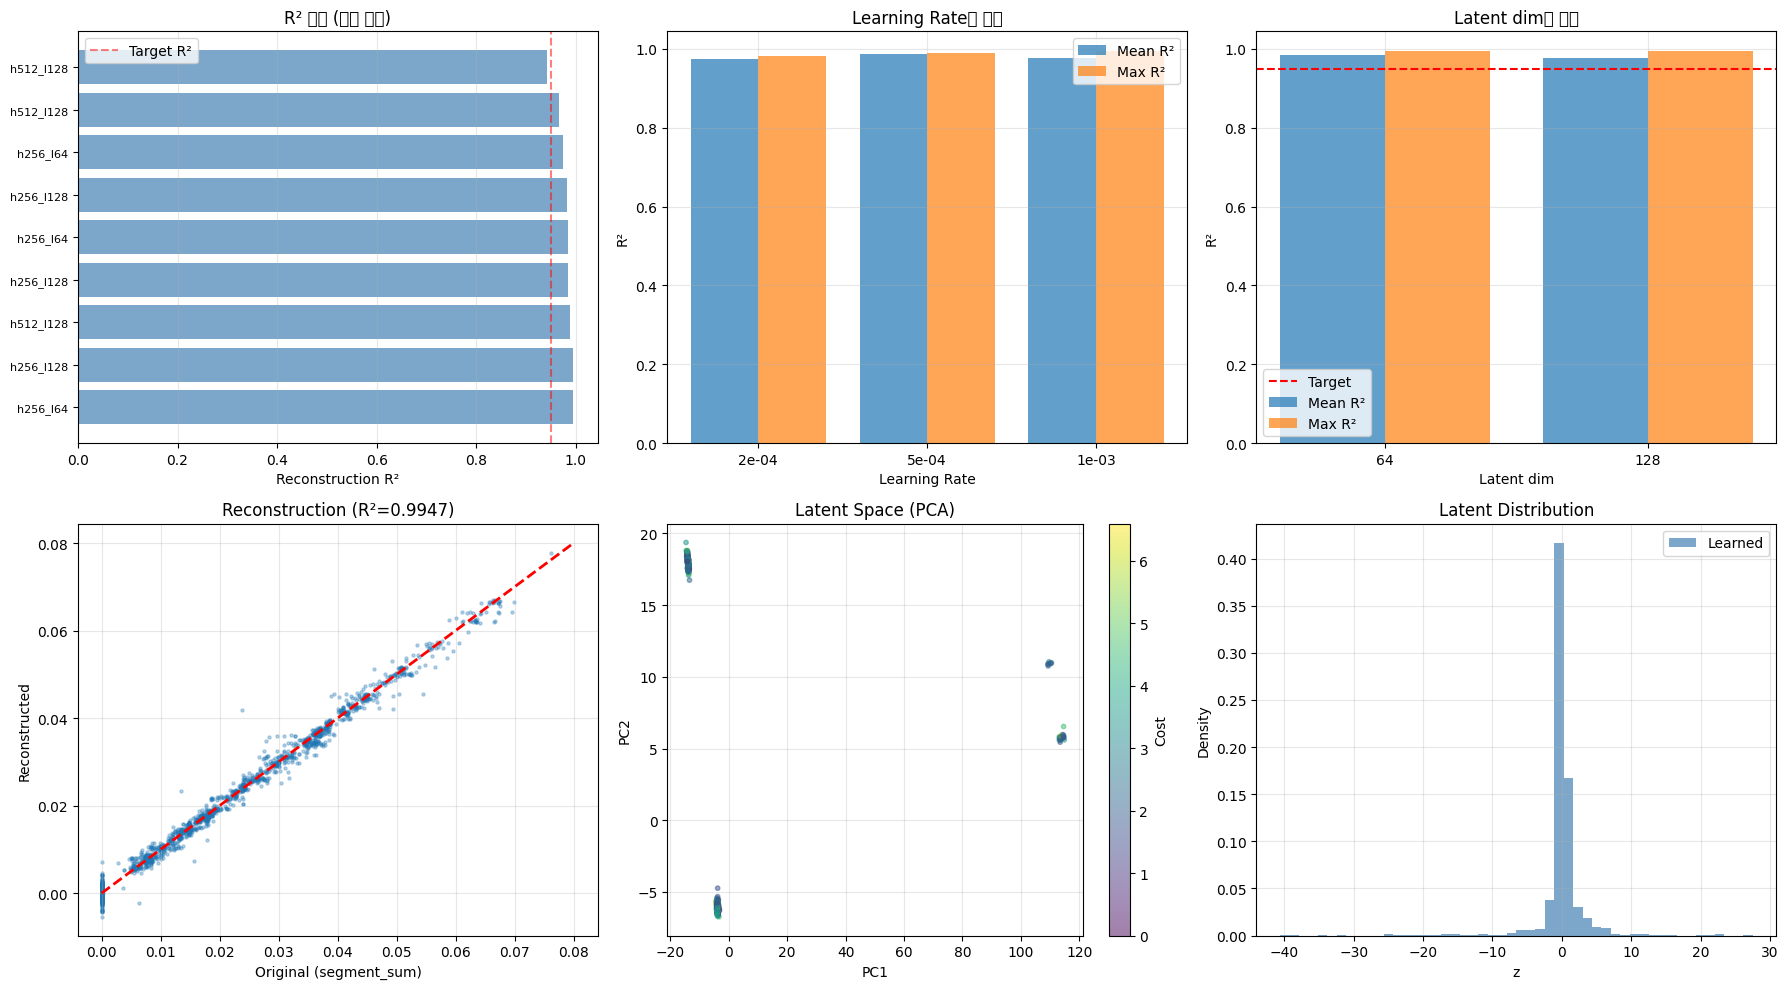


최적 설정: hidden=256, latent=64, lr=1e-03
최종 Reconstruction R²: 0.9947


In [28]:
# AE 하이퍼파라미터 탐색 결과 시각화
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. 상위 결과들의 R² 비교
ax = axes[0, 0]
top_results = all_results[:min(20, len(all_results))]  # 상위 20개
r2_vals = [r['recon_r2'] for r in top_results]
config_labels = [f"h{r['hidden_dim']}_l{r['latent_dim']}" for r in top_results]

ax.barh(range(len(r2_vals)), r2_vals, alpha=0.7, color='steelblue')
ax.set_yticks(range(len(config_labels)))
ax.set_yticklabels(config_labels, fontsize=8)
ax.axvline(x=0.95, color='red', linestyle='--', alpha=0.5, label='Target R²')
ax.set_xlabel('Reconstruction R²')
ax.set_title('R² 비교 (상위 결과)')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

# 2. Learning rate별 성능 비교
ax = axes[0, 1]
lr_groups = {}
for r in all_results:
    lr = r['lr']
    if lr not in lr_groups:
        lr_groups[lr] = []
    lr_groups[lr].append(r['recon_r2'])

lrs_sorted = sorted(lr_groups.keys())
lr_labels = [f'{lr:.0e}' for lr in lrs_sorted]
lr_r2_means = [np.mean(lr_groups[lr]) for lr in lrs_sorted]
lr_r2_maxs = [np.max(lr_groups[lr]) for lr in lrs_sorted]

x_pos = np.arange(len(lrs_sorted))
ax.bar(x_pos - 0.2, lr_r2_means, 0.4, label='Mean R²', alpha=0.7)
ax.bar(x_pos + 0.2, lr_r2_maxs, 0.4, label='Max R²', alpha=0.7)
ax.set_xticks(x_pos)
ax.set_xticklabels(lr_labels)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('R²')
ax.set_title('Learning Rate별 성능')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Latent dim별 성능 비교
ax = axes[0, 2]
latent_groups = {}
for r in all_results:
    ld = r['latent_dim']
    if ld not in latent_groups:
        latent_groups[ld] = []
    latent_groups[ld].append(r['recon_r2'])

latent_sorted = sorted(latent_groups.keys())
latent_labels = [str(ld) for ld in latent_sorted]
latent_r2_maxs = [np.max(latent_groups[ld]) for ld in latent_sorted]
latent_r2_means = [np.mean(latent_groups[ld]) for ld in latent_sorted]

x_pos = np.arange(len(latent_sorted))
ax.bar(x_pos - 0.2, latent_r2_means, 0.4, label='Mean R²', alpha=0.7)
ax.bar(x_pos + 0.2, latent_r2_maxs, 0.4, label='Max R²', alpha=0.7)
ax.axhline(y=0.95, color='red', linestyle='--', label='Target')
ax.set_xticks(x_pos)
ax.set_xticklabels(latent_labels)
ax.set_xlabel('Latent dim')
ax.set_ylabel('R²')
ax.set_title('Latent dim별 성능')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. 최적 모델 Reconstruction 품질
# 최적 모델 가져오기
best_model = all_results[0]['model']
best_model.eval()
val_recons, val_originals = [], []
with torch.no_grad():
    for segment_sizes_batch, features_batch, _ in val_loader:
        z, recon, segment_sum_vec = best_model(segment_sizes_batch, features_batch)
        val_recons.append(recon.cpu().numpy())
        val_originals.append(segment_sum_vec.cpu().numpy())

val_recons_flat = np.concatenate(val_recons).flatten()
val_originals_flat = np.concatenate(val_originals).flatten()

ax = axes[1, 0]
sample_idx = np.random.choice(len(val_originals_flat), min(5000, len(val_originals_flat)), replace=False)
ax.scatter(val_originals_flat[sample_idx], val_recons_flat[sample_idx], alpha=0.3, s=5)
ax.plot([val_originals_flat.min(), val_originals_flat.max()], 
        [val_originals_flat.min(), val_originals_flat.max()], 'r--', lw=2)
ax.set_xlabel('Original (segment_sum)')
ax.set_ylabel('Reconstructed')
final_r2 = r2_score(val_originals_flat, val_recons_flat)
ax.set_title(f'Reconstruction (R²={final_r2:.4f})')
ax.grid(True, alpha=0.3)

# 5. Latent space 시각화 (PCA)
all_z = []
all_costs = []
with torch.no_grad():
    for segment_sizes_batch, features_batch, labels_batch in val_loader:
        z, _, _ = best_model(segment_sizes_batch, features_batch)
        all_z.append(z.cpu().numpy())
        all_costs.append(labels_batch.cpu().numpy())
all_z = np.concatenate(all_z)
all_costs = np.concatenate(all_costs)

ax = axes[1, 1]
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
z_2d = pca.fit_transform(all_z)
scatter = ax.scatter(z_2d[:, 0], z_2d[:, 1], alpha=0.5, s=10, c=all_costs, cmap='viridis')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Latent Space (PCA)')
ax.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Cost')

# 6. Latent 분포 히스토그램
ax = axes[1, 2]
ax.hist(all_z.flatten(), bins=50, density=True, alpha=0.7, label='Learned', color='steelblue')
ax.set_xlabel('z')
ax.set_ylabel('Density')
ax.set_title('Latent Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n최적 설정: hidden={best_config['hidden_dim']}, latent={best_config['latent_dim']}, lr={best_config['lr']:.0e}")
print(f"최종 Reconstruction R²: {final_r2:.4f}")

In [31]:
# ============================================================
# Loss 함수 정의 (AE 버전)
# ============================================================

def reg_loss_fn(cost_pred, cost_true, loss_type='mse'):
    """기본 회귀 손실 (MSE 또는 MAE)"""
    if loss_type == 'mse':
        return F.mse_loss(cost_pred, cost_true)
    elif loss_type == 'huber':
        return F.smooth_l1_loss(cost_pred, cost_true)
    else:  # mae
        return F.l1_loss(cost_pred, cost_true)


def pair_loss_fn(cost_pred, cost_true, margin=0.1, delta=None):
    """
    Pairwise ranking loss
    
    Args:
        cost_pred: 예측값
        cost_true: 실제값
        margin: ranking loss margin
        delta: |y_i - y_j| > delta인 쌍만 사용 (None이면 모든 쌍 사용)
    """
    batch_size = cost_pred.size(0)
    if batch_size < 2:
        return torch.tensor(0.0, device=cost_pred.device)

    idx = torch.arange(batch_size, device=cost_pred.device)
    i_idx, j_idx = torch.meshgrid(idx, idx, indexing='ij')
    mask = i_idx < j_idx

    pred_i = cost_pred[i_idx[mask]]
    pred_j = cost_pred[j_idx[mask]]
    true_i = cost_true[i_idx[mask]]
    true_j = cost_true[j_idx[mask]]

    labels = torch.sign(true_j - true_i).float()
    valid = labels != 0
    
    # delta 필터링: 큰 차이가 있는 쌍만 사용
    if delta is not None:
        diff_abs = torch.abs(true_j - true_i)
        valid = valid & (diff_abs > delta)
    
    if valid.sum() == 0:
        return torch.tensor(0.0, device=cost_pred.device)

    return F.margin_ranking_loss(
        pred_j[valid].view(-1), pred_i[valid].view(-1), labels[valid].view(-1),
        margin=margin
    )


def smooth_loss_fn(model, z, noise_std=None, z_scale_factor=0.1):
    """
    Smoothness Loss
    
    latent space에 작은 노이즈를 추가했을 때 예측이 크게 변하지 않도록 규제
    
    Args:
        model: AECostPredictor 모델
        z: latent vectors
        noise_std: 노이즈 표준편차 (None이면 자동 계산)
        z_scale_factor: z-scale 기반 noise_std 계산용 비율
    """
    # z-scale 기반 noise_std 자동 계산
    z_scale = z.std(dim=0).mean().detach()
    if noise_std is None:
        noise_std = z_scale_factor * z_scale
    else:
        noise_std = noise_std * z_scale / 0.1  # 기본 z_scale=0.1 가정 보정
    
    z_noisy = z + noise_std * torch.randn_like(z)
    
    # anchor를 detach하여 z로의 gradient 차단 (인코더 보호)
    cost_anchor = model.predict_cost(z).detach()
    cost_noisy = model.predict_cost(z_noisy)
    
    return F.mse_loss(cost_noisy, cost_anchor)


def grad_direction_pair_loss_fn(model, z, alpha=None, margin=0.01, eps=1e-8, 
                                  z_scale_factor=0.05, enabled=True):
    """
    Gradient direction consistency loss
    
    z 공간에서 작은 변화에 대한 gradient 방향이 일관되도록 규제
    
    Args:
        model: AECostPredictor 모델
        z: latent vectors
        alpha: perturbation 크기 (None이면 자동 계산)
        margin: ranking loss margin
        eps: 수치 안정성
        z_scale_factor: z-scale 기반 alpha 계산용 비율
        enabled: False면 0 반환 (warmup 지원)
    """
    if not enabled:
        return torch.tensor(0.0, device=z.device)
    
    # z-scale 기반 alpha 자동 계산
    z_scale = z.std(dim=0).mean().detach()
    if alpha is None:
        alpha = z_scale_factor * z_scale
    else:
        alpha = alpha * z_scale / 0.1  # 기본 z_scale=0.1 가정 보정
    
    # z를 detach (augmentation loss이므로 인코더 보호)
    z = z.detach()
    z.requires_grad_(True)
    
    # Original cost prediction
    cost_z = model.predict_cost(z)
    grad_z = torch.autograd.grad(
        cost_z.sum(), z, create_graph=True, retain_graph=True
    )[0]
    grad_z_norm = grad_z.norm(dim=1, keepdim=True) + eps
    grad_z_normalized = grad_z / grad_z_norm
    
    # Perturbed z
    delta = alpha * torch.randn_like(z)
    z_perturbed = z + delta
    
    cost_z_perturbed = model.predict_cost(z_perturbed)
    grad_z_perturbed = torch.autograd.grad(
        cost_z_perturbed.sum(), z_perturbed, create_graph=True, retain_graph=True
    )[0]
    grad_z_perturbed_norm = grad_z_perturbed.norm(dim=1, keepdim=True) + eps
    grad_z_perturbed_normalized = grad_z_perturbed / grad_z_perturbed_norm
    
    # Cosine similarity loss
    cosine_sim = F.cosine_similarity(grad_z_normalized, grad_z_perturbed_normalized, dim=1)
    loss = (1 - cosine_sim).mean()
    
    return loss


print("AE용 Loss 함수 정의 완료!")
print("지원 함수:")
print("  - reg_loss_fn: MSE/Huber/MAE")
print("  - pair_loss_fn: Pairwise ranking loss")
print("  - smooth_loss_fn: Latent smoothness regularization")
print("  - grad_direction_pair_loss_fn: Gradient direction consistency")

AE용 Loss 함수 정의 완료!
지원 함수:
  - reg_loss_fn: MSE/Huber/MAE
  - pair_loss_fn: Pairwise ranking loss
  - smooth_loss_fn: Latent smoothness regularization
  - grad_direction_pair_loss_fn: Gradient direction consistency


In [ ]:
# Top-10 AE 모델 각각 저장
import os

save_dir = '/root/work/tenset/scripts/pre_experiments/model_final/checkpoints/ae_medium_v2'
os.makedirs(save_dir, exist_ok=True)

# all_results가 이미 R² 기준 내림차순 정렬되어 있음
top_10_results = all_results[:min(10, len(all_results))]

print("=" * 70)
print("Top-10 AE 모델 저장")
print("=" * 70)
print(f"저장 경로: {save_dir}")
print()

for rank, result in enumerate(top_10_results, 1):
    # 파일명 생성 (설정값 포함)
    filename = f"ae_rank{rank}_h{result['hidden_dim']}_l{result['latent_dim']}_lr{result['lr']:.0e}.pt"
    save_path = os.path.join(save_dir, filename)
    
    # 체크포인트 생성
    checkpoint = {
        'rank': rank,
        'model_state_dict': result['model'].state_dict(),
        'config': {
            'hidden_dim': result['hidden_dim'],
            'latent_dim': result['latent_dim'],
            'lr': result['lr'],
        },
        'metrics': {
            'recon_r2': result['recon_r2'],
        },
        'history': result['history']
    }
    
    torch.save(checkpoint, save_path)
    
    print(f"[{rank:2d}] {filename}")
    print(f"     R²={result['recon_r2']:.4f}")

print()
print("=" * 70)
print(f"✓ Top-10 AE 모델 저장 완료!")
print("=" * 70)

# 저장된 파일 목록 확인
print("\n저장된 파일 목록:")
for f in sorted(os.listdir(save_dir)):
    if f.startswith('ae_rank'):
        fpath = os.path.join(save_dir, f)
        size_mb = os.path.getsize(fpath) / (1024 * 1024)
        print(f"  - {f} ({size_mb:.2f} MB)")

In [25]:
# R² 디버깅 - all_results의 각 모델을 직접 평가
print("=" * 70)
print("각 모델의 실제 R² 재평가")
print("=" * 70)

for i, result in enumerate(all_results[:3]):
    model = result['model']
    model.eval()
    
    val_recons_test, val_originals_test = [], []
    with torch.no_grad():
        for segment_sizes_batch, features_batch, _ in val_loader:
            z, recon, segment_sum_vec = model(segment_sizes_batch, features_batch)
            val_recons_test.append(recon.cpu().numpy())
            val_originals_test.append(segment_sum_vec.cpu().numpy())
    
    val_recons_test_flat = np.concatenate(val_recons_test).flatten()
    val_originals_test_flat = np.concatenate(val_originals_test).flatten()
    actual_r2 = r2_score(val_originals_test_flat, val_recons_test_flat)
    
    print(f"[{i+1}] hidden={result['hidden_dim']}, latent={result['latent_dim']}, lr={result['lr']:.0e}")
    print(f"    저장된 R²: {result['recon_r2']:.4f}")
    print(f"    실제 R²: {actual_r2:.4f}")
    print()

각 모델의 실제 R² 재평가
[1] hidden=512, latent=128, lr=1e-03
    저장된 R²: 0.9983
    실제 R²: -1.8706

[2] hidden=256, latent=64, lr=1e-03
    저장된 R²: 0.9959
    실제 R²: 0.8004

[3] hidden=256, latent=128, lr=1e-03
    저장된 R²: 0.9957
    실제 R²: 0.9229



## AECostPredictor 사용 예제

Pretrained AE encoder를 로드하고 Cost Predictor를 학습하는 예제입니다.

In [53]:
# ============================================================
# Step 1: Pretrained AE 로드 및 AECostPredictor 초기화
# ============================================================

# 최적 AE 체크포인트 경로
best_ae_checkpoint_path = '/root/work/tenset/scripts/pre_experiments/model_final/checkpoints/ae_medium_v2/ae_rank1_h256_l64_lr1e-03.pt'

# 체크포인트 로드 (없으면 현재 학습한 모델 사용)
import os
if os.path.exists(best_ae_checkpoint_path):
    ae_checkpoint = torch.load(best_ae_checkpoint_path)
    print(f"✓ Loaded checkpoint: {best_ae_checkpoint_path}")
    print(f"  Config: {ae_checkpoint['config']}")
    print(f"  Metrics: {ae_checkpoint['metrics']}")
else:
    print(f"체크포인트 파일이 없습니다. 현재 학습한 모델 사용")
    ae_checkpoint = {
        'model_state_dict': pretrained_ae.state_dict(),
        'config': best_config,
        'metrics': {'recon_r2': all_results[0]['recon_r2']}
    }

# AECostPredictor 초기화
ae_cost_model = AECostPredictor(
    input_dim=train_flatten_features.shape[1],
    hidden_dim=ae_checkpoint['config']['hidden_dim'],
    latent_dim=ae_checkpoint['config']['latent_dim'],
    predictor_hidden=256,
    predictor_layers=3,
    dropout=0.1
).to(device)

# Pretrained encoder 로드
config, metrics = ae_cost_model.load_pretrained_encoder(ae_checkpoint)

print("\n" + "=" * 70)
print("AECostPredictor 초기화 완료!")
print("=" * 70)
print(f"Architecture:")
print(f"  Input dim: {train_flatten_features.shape[1]}")
print(f"  Hidden dim: {ae_checkpoint['config']['hidden_dim']}")
print(f"  Latent dim: {ae_checkpoint['config']['latent_dim']}")
print(f"  Predictor hidden: 256")
print(f"  Predictor layers: 3")

체크포인트 파일이 없습니다. 현재 학습한 모델 사용
Loaded 15 parameters from pretrained AE

AECostPredictor 초기화 완료!
Architecture:
  Input dim: 164
  Hidden dim: 256
  Latent dim: 64
  Predictor hidden: 256
  Predictor layers: 3


In [54]:
# ============================================================
# Step 2: Forward pass 테스트
# ============================================================

ae_cost_model.eval()

# 테스트: 한 배치 forward
test_batch = next(iter(val_loader))
segment_sizes_batch, features_batch, labels_batch = test_batch

with torch.no_grad():
    cost_pred, z = ae_cost_model(segment_sizes_batch, features_batch)
    
    print("=" * 70)
    print("Forward Pass 테스트")
    print("=" * 70)
    print(f"Input:")
    print(f"  Segment sizes: {segment_sizes_batch.shape}")
    print(f"  Features: {features_batch.shape}")
    print(f"  True costs: {labels_batch.shape}")
    print(f"\nOutput:")
    print(f"  Latent z: {z.shape}")
    print(f"  Predicted costs: {cost_pred.shape}")
    print(f"\nSample predictions (first 5):")
    for i in range(min(5, len(cost_pred))):
        print(f"  True: {labels_batch[i]:.4f}, Pred: {cost_pred[i]:.4f}")
    
    # Loss 계산
    mse_loss = reg_loss_fn(cost_pred, labels_batch, loss_type='mse')
    pair_loss = pair_loss_fn(cost_pred, labels_batch, margin=0.1)
    smooth_loss = smooth_loss_fn(ae_cost_model, z, noise_std=0.01)
    
    print(f"\nLoss 계산:")
    print(f"  MSE Loss: {mse_loss.item():.4f}")
    print(f"  Pair Loss: {pair_loss.item():.4f}")
    print(f"  Smooth Loss: {smooth_loss.item():.4f}")

print("\n✓ Forward pass 테스트 완료!")

Forward Pass 테스트
Input:
  Segment sizes: torch.Size([128])
  Features: torch.Size([1024, 164])
  True costs: torch.Size([128])

Output:
  Latent z: torch.Size([128, 64])
  Predicted costs: torch.Size([128])

Sample predictions (first 5):
  True: 1.0469, Pred: -0.0673
  True: 0.6754, Pred: -0.0678
  True: 1.9767, Pred: -0.0700
  True: 1.0208, Pred: -0.0681
  True: 1.5500, Pred: -0.1498

Loss 계산:
  MSE Loss: 8.4848
  Pair Loss: 0.1305
  Smooth Loss: 0.0001

✓ Forward pass 테스트 완료!


## 간단한 학습 예제 (Mini Training Loop)

Encoder는 freeze하고 Cost Predictor만 학습하는 간단한 예제입니다.

In [52]:
cost_train_indices, cost_val_indices = train_test_split(indices, test_size=0.98, random_state=SEED)

cost_train_segment_sizes = segment_sizes[cost_train_indices]
cost_val_segment_sizes = segment_sizes[cost_val_indices]
cost_train_labels = costs[cost_train_indices]
cost_val_labels = costs[cost_val_indices]

cost_train_feature_list = [features_list[i] for i in cost_train_indices]
cost_val_feature_list = [features_list[i] for i in cost_val_indices]

cost_train_flatten_features = np.concatenate(cost_train_feature_list, axis=0).astype(np.float32)
cost_val_flatten_features = np.concatenate(cost_val_feature_list, axis=0).astype(np.float32)


cost_train_loader = SegmentRegressionDataset(
    cost_train_segment_sizes, cost_train_flatten_features, cost_train_labels,
    batch_size=128, device=device, fea_norm_vec=fea_norm_vec, shuffle=True, seed=SEED
)
cost_val_loader = SegmentRegressionDataset(
    cost_val_segment_sizes, cost_val_flatten_features, cost_val_labels,
    batch_size=128, device=device, fea_norm_vec=fea_norm_vec, shuffle=False, seed=SEED
)

cost_X_train = cost_train_loader
cost_X_val = cost_val_loader
cost_y_train = cost_train_labels
cost_y_val = cost_val_labels
cost_train_dataset = cost_train_loader
cost_val_dataset = cost_val_loader

In [59]:
# ============================================================
# Mini Training: Encoder freeze, Predictor만 학습
# ============================================================

# Encoder freeze
# for param in ae_cost_model.get_encoder_params():
#     param.requires_grad = False

# Predictor만 학습
ae_cost_model = AECostPredictor(
    input_dim=train_flatten_features.shape[1],
    hidden_dim=ae_checkpoint['config']['hidden_dim'],
    latent_dim=ae_checkpoint['config']['latent_dim'],
    predictor_hidden=256,
    predictor_layers=3,
    dropout=0.05
).to(device)

# Pretrained encoder 로드
config, metrics = ae_cost_model.load_pretrained_encoder(ae_checkpoint)

optimizer = torch.optim.AdamW(ae_cost_model.get_predictor_params(), lr=5e-3)
# optimizer = torch.optim.AdamW(ae_cost_model.get_encoder_params(), lr=1e-7)

ae_cost_model.train()

print("=" * 70)
print("Mini Training (5 epochs, Predictor only)")
print("=" * 70)

for epoch in range(100):
    epoch_loss = 0.0
    n_batches = 0
    
    for segment_sizes_batch, features_batch, labels_batch in cost_train_loader:
        optimizer.zero_grad()
        
        cost_pred, z = ae_cost_model(segment_sizes_batch, features_batch)
        
        # Loss 계산 (간단한 MSE만 사용)
        loss = reg_loss_fn(cost_pred, labels_batch, loss_type='mse')
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    avg_loss = epoch_loss / n_batches
    
    # Validation
    ae_cost_model.eval()
    val_preds, val_trues = [], []
    with torch.no_grad():
        for segment_sizes_batch, features_batch, labels_batch in cost_val_loader:
            cost_pred, z = ae_cost_model(segment_sizes_batch, features_batch)
            val_preds.append(cost_pred.cpu().numpy())
            val_trues.append(labels_batch.cpu().numpy())
    
    val_preds = np.concatenate(val_preds)
    val_trues = np.concatenate(val_trues)
    val_r2 = r2_score(val_trues, val_preds)
    val_rmse = np.sqrt(np.mean((val_preds - val_trues) ** 2))
    
    print(f"Epoch {epoch+1}/5: Train Loss={avg_loss:.4f}, Val R²={val_r2:.4f}, Val RMSE={val_rmse:.4f}")
    
    ae_cost_model.train()

print("\n✓ Mini training 완료!")
print("\n모델 비교:")
print(f"  - Tenset MLP (baseline): 학습된 상태")
print(f"  - AECostPredictor: Pretrained AE encoder + 학습된 Cost Predictor")

Loaded 15 parameters from pretrained AE
Mini Training (5 epochs, Predictor only)
Epoch 1/5: Train Loss=10.7970, Val R²=-2.5215, Val RMSE=2.6309
Epoch 2/5: Train Loss=8.4618, Val R²=-1.8899, Val RMSE=2.3833
Epoch 3/5: Train Loss=5.5815, Val R²=-1.9026, Val RMSE=2.3886
Epoch 4/5: Train Loss=3.6510, Val R²=-2.6667, Val RMSE=2.6846
Epoch 5/5: Train Loss=2.5266, Val R²=-3.3995, Val RMSE=2.9407
Epoch 6/5: Train Loss=2.0680, Val R²=-4.8191, Val RMSE=3.3820
Epoch 7/5: Train Loss=2.0480, Val R²=-6.3089, Val RMSE=3.7903
Epoch 8/5: Train Loss=2.1273, Val R²=-6.7269, Val RMSE=3.8971
Epoch 9/5: Train Loss=2.1184, Val R²=-5.6536, Val RMSE=3.6163
Epoch 5/5: Train Loss=2.5266, Val R²=-3.3995, Val RMSE=2.9407
Epoch 6/5: Train Loss=2.0680, Val R²=-4.8191, Val RMSE=3.3820
Epoch 7/5: Train Loss=2.0480, Val R²=-6.3089, Val RMSE=3.7903
Epoch 8/5: Train Loss=2.1273, Val R²=-6.7269, Val RMSE=3.8971
Epoch 9/5: Train Loss=2.1184, Val R²=-5.6536, Val RMSE=3.6163
Epoch 10/5: Train Loss=2.0881, Val R²=-4.3843, Val

In [60]:
# ============================================================
# 모델 요약 및 비교
# ============================================================

print("=" * 70)
print("모델 구조 요약")
print("=" * 70)

print("\n1. SegmentAE (Autoencoder)")
print("   - 용도: Feature reconstruction 학습")
print("   - 구조: Segment Encoder → Segment Sum → AE Encoder → Decoder")
print("   - 출력: Reconstructed segment sum vectors")
print("   - 학습: Reconstruction loss만 사용")

print("\n2. AECostPredictor (Cost Predictor)")
print("   - 용도: Cost prediction")
print("   - 구조: [Pretrained AE Encoder] → Cost Predictor")
print("   - 출력: Predicted costs")
print("   - 학습: Regression + Ranking + Smoothness losses")
print("   - 특징: Deterministic encoding (no sampling)")

print("\n3. VAECostPredictor와의 차이점")
print("   - VAE: Stochastic encoding (reparameterization trick)")
print("   - VAE: KL divergence loss 사용")
print("   - AE: Deterministic encoding")
print("   - AE: KL divergence 없음 (더 단순)")

print("\n" + "=" * 70)
print("파라미터 수 비교")
print("=" * 70)

total_params = sum(p.numel() for p in ae_cost_model.parameters())
encoder_params = sum(p.numel() for p in ae_cost_model.get_encoder_params())
predictor_params = sum(p.numel() for p in ae_cost_model.get_predictor_params())

print(f"Total parameters: {total_params:,}")
print(f"  - Encoder (pretrained): {encoder_params:,}")
print(f"  - Predictor (trainable): {predictor_params:,}")
print(f"  - Ratio: {predictor_params/total_params*100:.1f}% trainable")

print("\n" + "=" * 70)
print("✓ AECostPredictor 구현 완료!")
print("=" * 70)

모델 구조 요약

1. SegmentAE (Autoencoder)
   - 용도: Feature reconstruction 학습
   - 구조: Segment Encoder → Segment Sum → AE Encoder → Decoder
   - 출력: Reconstructed segment sum vectors
   - 학습: Reconstruction loss만 사용

2. AECostPredictor (Cost Predictor)
   - 용도: Cost prediction
   - 구조: [Pretrained AE Encoder] → Cost Predictor
   - 출력: Predicted costs
   - 학습: Regression + Ranking + Smoothness losses
   - 특징: Deterministic encoding (no sampling)

3. VAECostPredictor와의 차이점
   - VAE: Stochastic encoding (reparameterization trick)
   - VAE: KL divergence loss 사용
   - AE: Deterministic encoding
   - AE: KL divergence 없음 (더 단순)

파라미터 수 비교
Total parameters: 406,593
  - Encoder (pretrained): 256,576
  - Predictor (trainable): 150,017
  - Ratio: 36.9% trainable

✓ AECostPredictor 구현 완료!
